# Analysis of Lebron James' Home,Away and Both Games Performance of the All-time Regular Seasons

Thanks to ESPN.com and Lebron James :)

## Data Preperation

In [1]:
import pandas as pd
import requests
import warnings
warnings.filterwarnings('ignore')

### Run html_data_requester

In [2]:
def html_data_requester(years=()):
    
    html_data=[pd.read_html(requests.get("https://www.espn.com.au/nba/player/gamelog/_/id/1966/type/nba/year/"+years[i]).text) for i in range(len(years))]
    
    return html_data
    

In [3]:
years=("2022","2021","2020","2019","2018","2017","2016","2015","2014","2013","2012","2011","2010","2009","2008","2007","2006","2005","2004","2003")

#istenilen verilerin yılları

In [4]:
html_data=html_data_requester(years)


### Run df_preper, date_formatter

In [5]:
def date_formatter(df,year): 
    
    df["Date"]=df["Date"].apply(lambda x:x.replace(x[0:3],""))
    df["Date"]=df["Date"].apply(lambda x:year +"/"+x.replace(" ",""))
    
    if df.Date.isin(["AT OKLAHOMA CITY OK"]).all()==False:
        
        df.drop(df[df.Date.isin([year+"/OKLAHOMACITYOK"])].index,inplace=True)

    ##çok spesifik ve bozukluk yaratan bir satır, 2 yılda birden bulunuyordu , genericlestirdim 
    
    df["Date"]=pd.to_datetime(df["Date"])
    
    if df[df.Date.isin([year+"-01-01"])].Date.any()==True:
    
        df.replace(year+"-01-01",str(int(year)+1),inplace=True) 
          
    df.set_index("Date",inplace=True)
    df["Month"]=df.index.month_name()
    df["Year"]=df.index.year    
    df.reset_index(inplace=True)

    return df

In [6]:
def df_preper(html_data,years):
    
    tables=[]
    df_all=pd.DataFrame()
    
    
    for df,j in zip(html_data,range(1,len(html_data))):
        
        values=[]
    
        for k in range(len(df)):
        
            try:
            
                df[k].Date
                
                #bunun sebebi gelen verideki tablolarda column isimlerinde Date yoksa onu depoalamak
            
            except AttributeError:
            
                values.append(k)
                
                #burda depoladık o değerleri. sonrasında slicing yapcaz, yani ihtiyacımız kadarın tabloyu almamız sağlandı 
            
        if len(values)==2:
        
            ##playoff oynamadıgı  sene ve güncel 2021-22 senesi icin values.size()=2 demek durumunda kaldık. o senelerdeki tabloları düzenliyoruz
            
            df=df[:values[0]]
            df=pd.concat([x for x in df])
            df.reset_index(inplace=True,drop=True)
            
            for index,row in enumerate(df.Date):
                                
                if "ALL-STAR" in row.upper():
        
                    df.drop(index,inplace=True)   
                    df.reset_index(inplace=True,drop=True)
                     
                elif row=="january":
            
                    df_winter=df.iloc[index:]
                    df_summer=df.iloc[:index]
    
            for k in ["october","november","december","january","february","march","april"]:
    
                df_winter=df_winter.drop(df_winter[df_winter.Date.isin([k])].index)
                df_summer=df_summer.drop(df_summer[df_summer.Date.isin([k])].index)
            
            date_formatter(df_winter,years[j])
            date_formatter(df_summer,years[j-1])
    
            df_=pd.concat([df_winter,df_summer])
    
            season_column=df_.Date.dt.year.unique()
            season_column.sort()
            df_["Season"]=str(season_column[0])+"-"+str(season_column[1]) 
            
            tables.append(df_)
        
        else:
            
            #burda da 2den farklı yani play-off oynadıgı senelerdeki tabloları düzenliyoruz
        
            df=df[values[0]+1:values[1]]
            df=pd.concat([x for x in df]);
            df.reset_index(inplace=True,drop=True)
            
            for index,row in enumerate(df.Date):
              
                if "ALL-STAR" in row.upper():
        
                    df.drop(index,inplace=True)
                    df.reset_index(inplace=True,drop=True)
                
                elif row=="january":
            
                    df_winter=df.iloc[index:]
                    df_summer=df.iloc[:index]
    
            for k in ["october","november","december","january","february","march","april"]:
              
                df_winter=df_winter.drop(df_winter[df_winter.Date.isin([k])].index)
                df_summer=df_summer.drop(df_summer[df_summer.Date.isin([k])].index)
                
            date_formatter(df_winter,years[j])
            date_formatter(df_summer,years[j-1])
            
            #dateformatteri hem ifte hem de elsede kullanmamın sebebi years atamalarını yapıyor olmaları. years atamalarını da en genel for döngüsü icinde yaptırıyorum,daha az loop kullanmak maksadıyla
    
            df_=pd.concat([df_winter,df_summer])
    
            season_column=df_.Date.dt.year.unique()
            season_column.sort()
            df_["Season"]=str(season_column[0])+"-"+str(season_column[1])
            
            tables.append(df_)
            
    
    df_all=pd.concat([x for x in tables])
    df_all.reset_index(inplace=True,drop=True)
    df_all=df_all.sort_values(by=["Date"])
    df_all.reset_index(inplace=True,drop=True) 
    
    for column in df_all[['MIN','FG%','3P%','FT%','REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS']]:
        
        df_all[column]=pd.to_numeric(df_all[column])
        
    
    
    return df_all


In [7]:
df_all=df_preper(html_data,years)

In [8]:
df_all.head()

,Date,OPP,Result,MIN,FG,FG%,3PT,3P%,FT,FT%,REB,AST,BLK,STL,PF,TO,PTS,Month,Year,Season
0,2003-10-30,@SAC,L106-92,42.0,12-20,60.0,0-2,0.0,1-3,33.3,6.0,9.0,0.0,4.0,3.0,2.0,25.0,October,2003,2003-2004
1,2003-10-31,@PHX,L95-86,41.0,8-17,47.1,1-5,20.0,4-7,57.1,12.0,8.0,0.0,1.0,1.0,7.0,21.0,October,2003,2003-2004
2,2003-11-02,@POR,L104-85,39.0,3-12,25.0,0-1,0.0,2-2,100.0,4.0,6.0,0.0,2.0,3.0,2.0,8.0,November,2003,2003-2004
3,2003-11-06,vsDEN,L93-89,41.0,3-11,27.3,0-2,0.0,1-1,100.0,11.0,7.0,3.0,2.0,1.0,2.0,7.0,November,2003,2003-2004
4,2003-11-08,@IND,L91-90,44.0,8-18,44.4,1-2,50.0,6-7,85.7,5.0,3.0,0.0,0.0,2.0,7.0,23.0,November,2003,2003-2004


### Run df_home_away_formatter

In [9]:
def df_home_away_formatter(df):
    away=[]
    home=[]
    
    df_away=pd.DataFrame()
    df_home=pd.DataFrame()
    
    for k in df["OPP"]:
    
        if "@" in k :

            away.append(df[df["OPP"].isin([k])])
        
        elif "vs" in k:
            
            home.append(df[df["OPP"].isin([k])])

        
    df_away=pd.concat(away)
    df_away.drop_duplicates(keep="first",inplace=True)
    df_away.sort_values(by=["Date"],inplace=True)
    df_away.reset_index(inplace=True,drop=True)
    
    df_home=pd.concat(home)
    df_home.drop_duplicates(keep="first",inplace=True)
    df_home.sort_values(by=["Date"],inplace=True)
    df_home.reset_index(inplace=True,drop=True)
     
    return (df_home,df_away)
    

In [10]:
df_all_home,df_all_away=df_home_away_formatter(df_all)

In [11]:
df_all_home.head()

,Date,OPP,Result,MIN,FG,FG%,3PT,3P%,FT,FT%,REB,AST,BLK,STL,PF,TO,PTS,Month,Year,Season
0,2003-11-06,vsDEN,L93-89,41.0,3-11,27.3,0-2,0.0,1-1,100.0,11.0,7.0,3.0,2.0,1.0,2.0,7.0,November,2003,2003-2004
1,2003-11-09,vsWSH,W111-98,45.0,8-19,42.1,0-0,0.0,1-4,25.0,8.0,9.0,1.0,1.0,1.0,2.0,17.0,November,2003,2003-2004
2,2003-11-11,vsNY,W94-80,34.0,7-12,58.3,3-3,100.0,0-0,0.0,5.0,4.0,1.0,1.0,0.0,2.0,17.0,November,2003,2003-2004
3,2003-11-16,vsPHI,W91-88 OT,47.0,10-19,52.6,0-1,0.0,2-4,50.0,5.0,8.0,2.0,1.0,2.0,5.0,22.0,November,2003,2003-2004
4,2003-11-19,vsLAC,W103-95,39.0,6-16,37.5,0-2,0.0,2-4,50.0,7.0,8.0,1.0,0.0,2.0,3.0,14.0,November,2003,2003-2004


In [12]:
df_all_away.head()

,Date,OPP,Result,MIN,FG,FG%,3PT,3P%,FT,FT%,REB,AST,BLK,STL,PF,TO,PTS,Month,Year,Season
0,2003-10-30,@SAC,L106-92,42.0,12-20,60.0,0-2,0.0,1-3,33.3,6.0,9.0,0.0,4.0,3.0,2.0,25.0,October,2003,2003-2004
1,2003-10-31,@PHX,L95-86,41.0,8-17,47.1,1-5,20.0,4-7,57.1,12.0,8.0,0.0,1.0,1.0,7.0,21.0,October,2003,2003-2004
2,2003-11-02,@POR,L104-85,39.0,3-12,25.0,0-1,0.0,2-2,100.0,4.0,6.0,0.0,2.0,3.0,2.0,8.0,November,2003,2003-2004
3,2003-11-08,@IND,L91-90,44.0,8-18,44.4,1-2,50.0,6-7,85.7,5.0,3.0,0.0,0.0,2.0,7.0,23.0,November,2003,2003-2004
4,2003-11-13,@MIA,L88-83,42.0,6-15,40.0,2-5,40.0,4-6,66.7,3.0,7.0,1.0,2.0,3.0,4.0,18.0,November,2003,2003-2004


## Plots and Analysis

In [13]:
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.io as pio

### Analysis 

#### Home & Away Games

In [14]:
df_all_home.groupby(["Season"])["PTS","FG%","MIN"].mean().reset_index()

,Season,PTS,FG%,MIN
0,2003-2004,21.289474,41.342105,39.131579
1,2004-2005,27.450000,48.105000,41.575000
2,2005-2006,30.948718,49.720513,42.717949
3,2006-2007,26.435897,48.961538,40.948718
4,2007-2008,29.358974,47.325641,40.692308
5,2008-2009,25.350000,50.090000,36.200000
6,2009-2010,28.394737,50.934211,38.605263
7,2010-2011,25.634146,49.646341,38.463415
8,2011-2012,26.312500,54.556250,36.750000
9,2012-2013,26.102564,59.053846,36.589744


In [15]:
df_all_away.groupby(["Season"])["PTS","FG%","MIN"].mean().reset_index()

,Season,PTS,FG%,MIN
0,2003-2004,20.609756,39.934146,39.878049
1,2004-2005,26.925000,46.505000,43.125000
2,2005-2006,31.775000,46.402500,42.375000
3,2006-2007,28.230769,45.610256,40.974359
4,2007-2008,30.694444,48.952778,40.027778
5,2008-2009,31.463415,48.100000,39.243902
6,2009-2010,31.026316,49.036842,39.500000
7,2010-2011,27.894737,51.944737,39.131579
8,2011-2012,28.033333,52.040000,38.333333
9,2012-2013,27.243243,54.783784,38.972973


#### Triple-Double & Double-Double per Regular Season Stats

In [16]:
from itertools import combinations

In [17]:
comb_double_double=list(combinations(["PTS","AST","REB","BLK","STL"],2))

In [18]:
double_double=[]
for k in range(1,len(comb_double_double)+1):
    
    for j in range(1,2):
        
        column1=comb_double_double[k-1][j-1]
        column2=comb_double_double[k-1][j]
        double_double.append(df_all.loc[(df_all[column1]>=10) & (df_all[column2]>=10)])

In [19]:
df_double_double=pd.concat([x for x in double_double])
df_double_double.drop_duplicates(keep="first",inplace=True)
df_double_double.reset_index(inplace=True,drop=True)

In [20]:
df_double_double.shape

(529, 20)

In [20]:
df_double_double.groupby(["Date"]).sum().reset_index().head()

,Date,MIN,FG%,3P%,FT%,REB,AST,BLK,STL,PF,TO,PTS,Year
0,2003-10-31,41.0,47.1,20.0,57.1,12.0,8.0,0.0,1.0,1.0,7.0,21.0,2003
1,2003-11-30,55.0,50.0,50.0,66.7,16.0,7.0,1.0,1.0,1.0,8.0,33.0,2003
2,2003-12-21,42.0,50.0,0.0,83.3,6.0,10.0,2.0,2.0,2.0,4.0,32.0,2003
3,2003-12-29,39.0,65.2,0.0,100.0,10.0,9.0,0.0,3.0,1.0,5.0,32.0,2003
4,2003-12-31,38.0,45.0,0.0,66.7,10.0,4.0,0.0,0.0,2.0,4.0,22.0,2003


In [21]:
df_double_double.groupby(df_double_double.Result.apply(lambda x: x.split("-")[0][0]))["TO","MIN"].mean().reset_index()

,Result,TO,MIN
0,L,4.139860,40.237762
1,W,3.494819,38.624352


In [22]:
df_double_double.groupby(df_double_double.OPP.apply(lambda x : x[0:1]))["TO","MIN"].mean().reset_index()

,OPP,TO,MIN
0,@,3.721569,39.368627
1,v,3.620438,38.773723


In [23]:
comb_triple_double=list(combinations(["PTS","AST","REB","BLK","STL"],3))

In [24]:
triple_double=[]
for k in range(1,len(comb_triple_double)+1):
    
    for j in range(1,2):
        
        column1=comb_triple_double[k-1][j-1]
        column2=comb_triple_double[k-1][j]
        column3=comb_triple_double[k-1][2]
        
        triple_double.append(df_all.loc[(df_all[column1]>=10) & (df_all[column2]>=10) & (df_all[column3]>=10)])

In [25]:
df_triple_double=pd.concat([x for x in triple_double])
df_triple_double.drop_duplicates(keep="first",inplace=True)
df_triple_double.reset_index(inplace=True,drop=True)

In [26]:
df_triple_double.shape

(105, 20)

In [27]:
df_triple_double.groupby(["Season"]).size().reset_index()

,Season,0
0,2004-2005,4
1,2005-2006,5
2,2006-2007,1
3,2007-2008,7
4,2008-2009,7
5,2009-2010,4
6,2010-2011,4
7,2012-2013,4
8,2013-2014,1
9,2014-2015,2


In [28]:
df_double_double.groupby(["Season"]).size().reset_index()

,Season,0
0,2003-2004,12
1,2004-2005,25
2,2005-2006,21
3,2006-2007,16
4,2007-2008,31
5,2008-2009,29
6,2009-2010,31
7,2010-2011,31
8,2011-2012,23
9,2012-2013,36


In [29]:
df_triple_double.groupby(["Date"]).sum().reset_index().head()

,Date,MIN,FG%,3P%,FT%,REB,AST,BLK,STL,PF,TO,PTS,Year
0,2005-01-20,44.0,68.8,100.0,66.7,11.0,10.0,0.0,4.0,4.0,2.0,27.0,2005
1,2005-01-23,43.0,54.2,0.0,100.0,12.0,10.0,1.0,1.0,1.0,3.0,28.0,2005
2,2005-04-10,47.0,57.7,53.8,100.0,10.0,10.0,1.0,2.0,2.0,3.0,40.0,2005
3,2005-04-21,48.0,43.5,25.0,50.0,14.0,14.0,1.0,0.0,1.0,2.0,27.0,2005
4,2005-11-20,47.0,58.3,0.0,80.0,11.0,10.0,1.0,1.0,1.0,5.0,36.0,2005


In [30]:
df_triple_double.groupby(df_triple_double.Result.apply(lambda x: x.split("-")[0][0]))["PTS","AST","REB","STL","BLK"].mean().reset_index()

,Result,PTS,AST,REB,STL,BLK
0,L,27.1200,12.240,11.9200,1.680,1.1200
1,W,27.3625,11.575,11.5375,1.525,0.9375


In [31]:
df_triple_double.groupby(df_triple_double.OPP.apply(lambda x : x[0:1]))["PTS","AST","REB","STL","BLK"].mean().reset_index()

,OPP,PTS,AST,REB,STL,BLK
0,@,27.701754,11.666667,11.631579,1.789474,0.894737
1,v,26.833333,11.812500,11.625000,1.291667,1.083333


#### Season and General Stats

In [32]:
df_all.groupby(["Season"]).agg({"PTS":["min","max","first","last","mean"]}).reset_index()

Season   PTS                             
                min   max first  last       mean
0   2003-2004   4.0  41.0  25.0  17.0  20.936709
1   2004-2005   3.0  56.0  28.0  27.0  27.187500
2   2005-2006  14.0  52.0  31.0  17.0  31.367089
3   2006-2007   8.0  41.0  26.0  24.0  27.333333
4   2007-2008  10.0  51.0  10.0  27.0  30.000000
5   2008-2009  11.0  55.0  22.0  37.0  28.444444
6   2009-2010  12.0  48.0  38.0  19.0  29.710526
7   2010-2011  12.0  51.0  31.0  34.0  26.721519
8   2011-2012  14.0  41.0  37.0  32.0  27.145161
9   2012-2013  13.0  40.0  26.0  24.0  26.657895
10  2013-2014  13.0  61.0  17.0  27.0  27.064103
11  2014-2015  11.0  42.0  17.0  21.0  25.328571
12  2015-2016  12.0  37.0  25.0  34.0  25.103896
13  2016-2017  16.0  44.0  19.0  32.0  26.360000
14  2017-2018  10.0  57.0  29.0  10.0  27.469880
15  2018-2019  13.0  51.0  26.0  27.0  27.214286
16  2019-2020  13.0  40.0  18.0  17.0  25.308824
17  2020-2021   4.0  46.0  22.0  25.0  24.565217
18  2021-2022  10.0  56.0  34.0  39.0  30.017857

In [33]:
df_all.groupby(["Season"])["3P%","FG%"].mean().reset_index()

,Season,3P%,FG%
0,2003-2004,22.487342,40.611392
1,2004-2005,30.611250,47.305000
2,2005-2006,28.778481,48.040506
3,2006-2007,27.997436,47.285897
4,2007-2008,27.180000,48.106667
5,2008-2009,29.106173,49.082716
6,2009-2010,31.501316,49.985526
7,2010-2011,28.446835,50.751899
8,2011-2012,27.311290,53.338710
9,2012-2013,36.513158,56.975000


### Plots

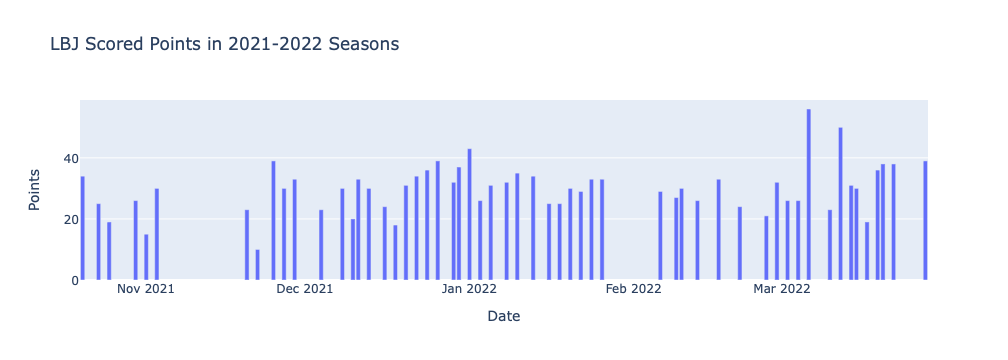

In [41]:
fig=px.bar(df_all[df_all.Season.isin(["2021-2022"])],x="Date",y="PTS",title="LBJ Scored Points in 2021-2022 Seasons")
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Points")
pio.write_html(fig, file='bar_figure.html', auto_open=True)
fig.show()

Text(0.5, 1.0, 'Average points by Lebron James in per Regular Seasons')

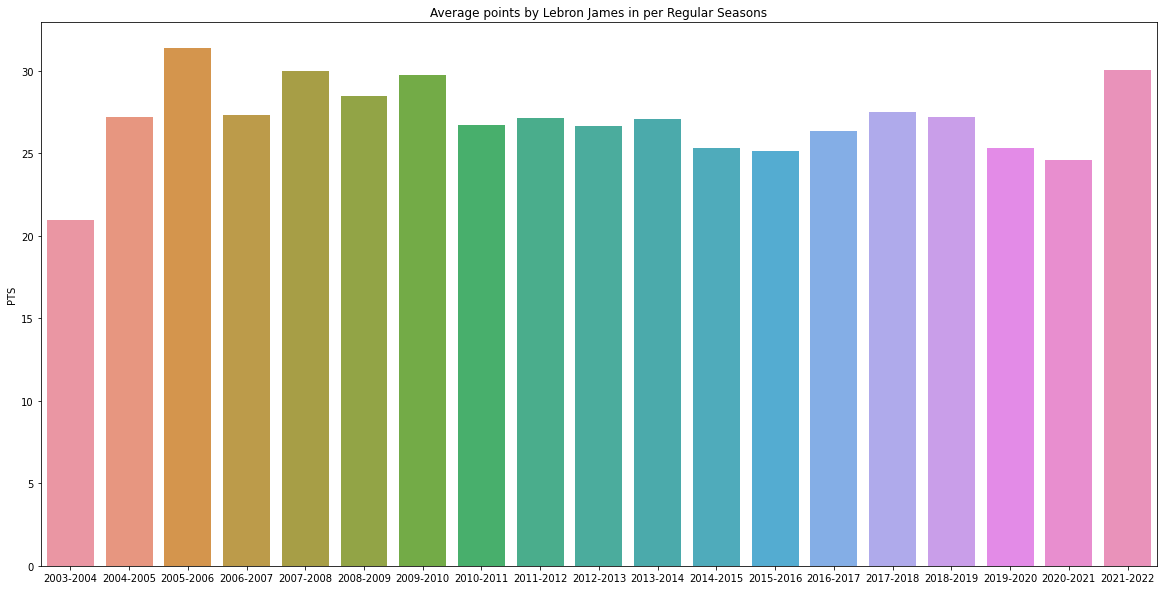

In [42]:
plt.figure(figsize=(20,10))
sns.barplot(x=df_all.Season.unique(),y=df_all.groupby(["Season"])["PTS"].mean())
plt.title("Average points by Lebron James in per Regular Seasons")

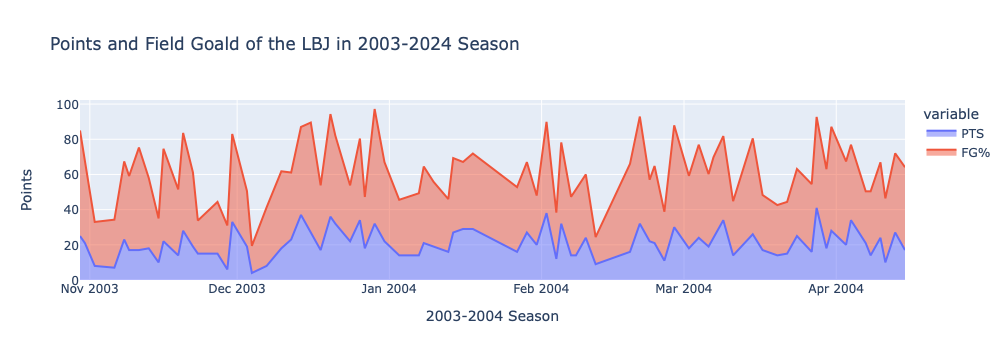

In [44]:
fig=px.area(df_all[df_all.Season.isin(["2003-2004"])],x="Date",y=["PTS","FG%"],title="Points and Field Goald of the LBJ in 2003-2024 Season")
fig.update_layout(
    xaxis_title="2003-2004 Season",
    yaxis_title="Points")
pio.write_html(fig, file='area_figure.html', auto_open=True)
fig.show()

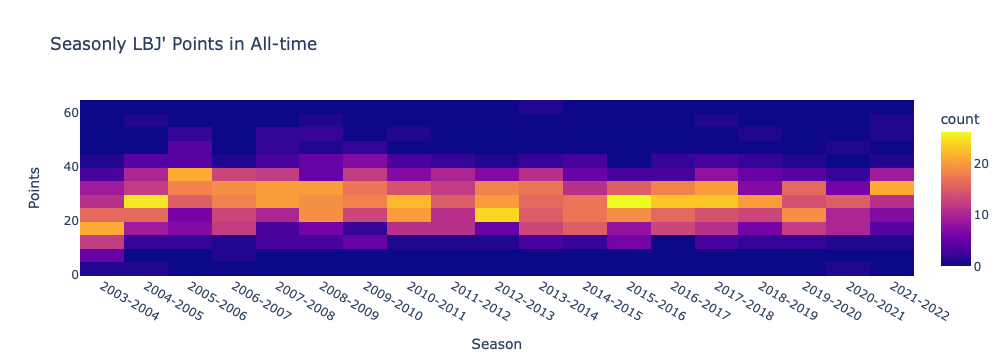

In [45]:
fig=px.density_heatmap(df_all,x="Season",y="PTS",title="Seasonly LBJ' Points in All-time")
fig.update_layout(
    xaxis_title="Season",
    yaxis_title="Points")
pio.write_html(fig, file='density_figure.html', auto_open=True)
fig.show()

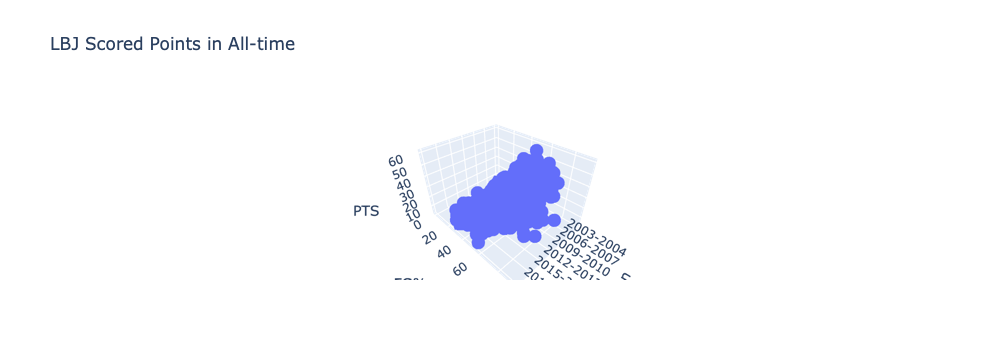

In [46]:
fig=px.scatter_3d(df_all,x="Season",y="FG%",z="PTS",title="LBJ Scored Points in All-time ")
fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Points")

pio.write_html(fig, file='figure.html', auto_open=True)
fig.show()

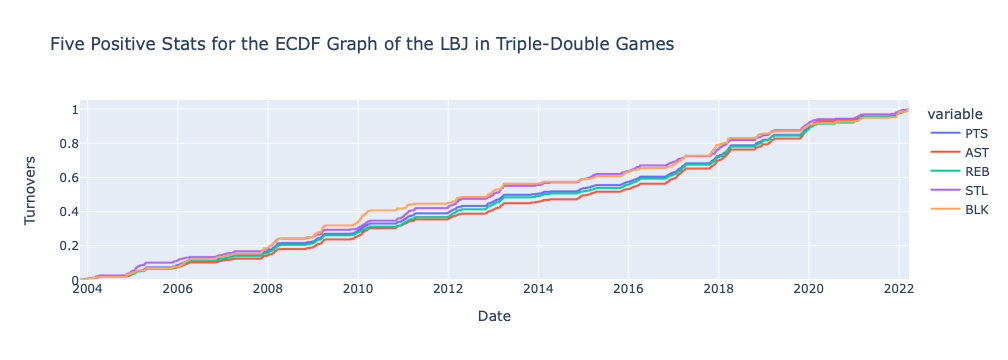

In [47]:
fig=px.ecdf(df_double_double,x="Date",y=["PTS","AST","REB","STL","BLK"],title="Five Positive Stats for the ECDF Graph of the LBJ in Triple-Double Games")
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Turnovers")

pio.write_html(fig, file='ecdf_figure.html', auto_open=True)
fig.show()

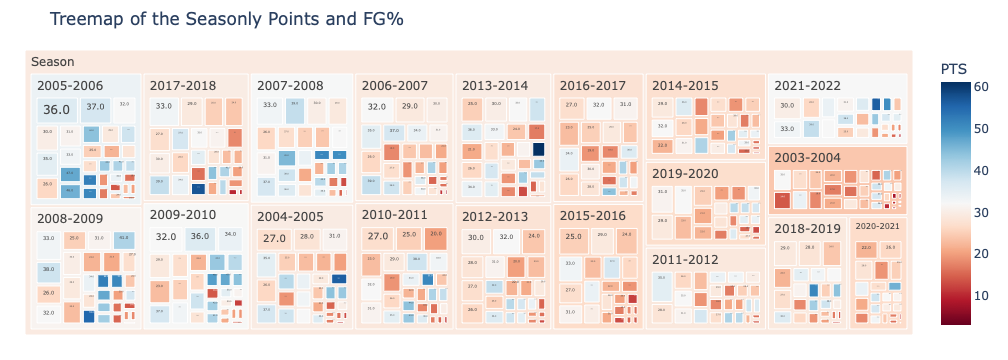

In [48]:
fig = px.treemap(df_all, path=[px.Constant("Season"),"Season","PTS","FG%"], values="PTS",
                  color="PTS", hover_data=["Season"],
                  color_continuous_scale='RdBu',title="Treemap of the Seasonly Points and FG%")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
pio.write_html(fig, file='treemap_figure.html', auto_open=True)
fig.show()

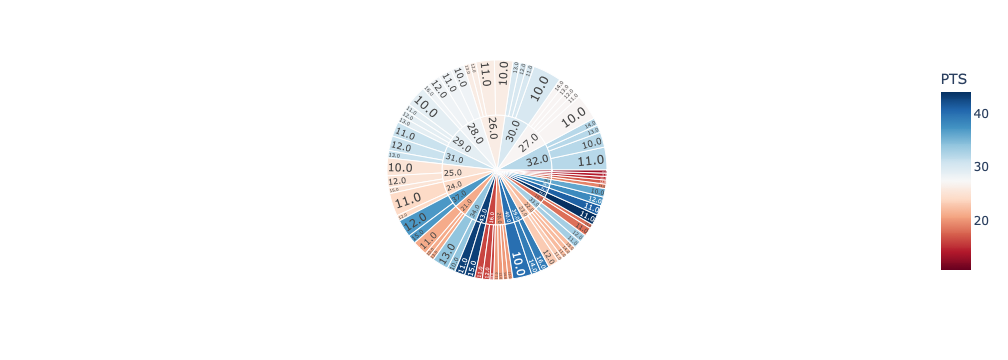

In [49]:
fig = px.sunburst(df_triple_double, path=["PTS", "AST"], values="PTS",
                  color="PTS", hover_data=["REB"],
                  color_continuous_scale='RdBu',
                  color_continuous_midpoint=df_triple_double["PTS"].mean())
pio.write_html(fig, file='sunburst_figure.html', auto_open=True)
fig.show()

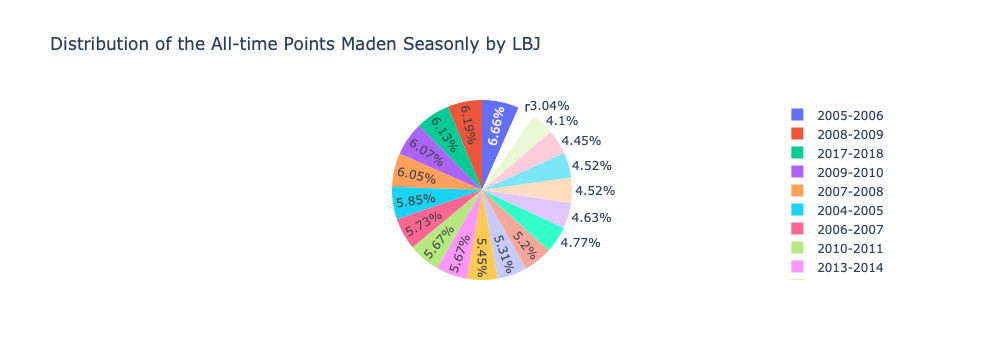

In [50]:
fig = px.pie(df_all, values="PTS", names="Season", title="Distribution of the All-time Points Maden Seasonly by LBJ")
pio.write_html(fig, file='pie_figure.html', auto_open=True)
fig.show()

## Machine Learning 

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import sklearn.metrics as metrics 
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np


### Build Random Forest Regression Model

In [35]:
df_all_copy=df_all.copy()

In [36]:
df_all_copy.Result=df_all_copy.Result.apply(lambda x: x.split("-")[0][0])
df_all_copy.OPP=df_all_copy.OPP.apply(lambda x : x[0:1])
df_all_copy.Month=df_all_copy.Date.dt.month

In [37]:
X=df_all_copy[["OPP","Result","Season","Month","Year","MIN","FG%","3P%","FT%","TO","AST"]].values

In [38]:
y=df_all_copy.PTS.values

In [39]:
ct=ColumnTransformer(transformers=[("encoder",OneHotEncoder(),[0,1,2])],remainder="passthrough")

In [40]:
X = np.array(ct.fit_transform(X))

In [41]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,10,2003,42.0,60.0,0.0,33.3,2.0,9.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,10,2003,41.0,47.1,20.0,57.1,7.0,8.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,11,2003,39.0,25.0,0.0,100.0,2.0,6.0
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,11,2003,41.0,27.3,0.0,100.0,2.0,7.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,11,2003,44.0,44.4,50.0,85.7,7.0,3.0


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 1/3, random_state = 42)

In [43]:
model=RandomForestRegressor()

In [44]:
model.fit(X_train,y_train)

RandomForestRegressor()

In [45]:
y_pred =model.predict(X_test)

In [46]:
y_pred=y_pred.round()

In [47]:
df_pred=pd.DataFrame({"prediction":y_pred,"test":y_test})

In [48]:
df_pred.drop(np.where(df_pred.prediction<0)[0],inplace=True)

<AxesSubplot:>

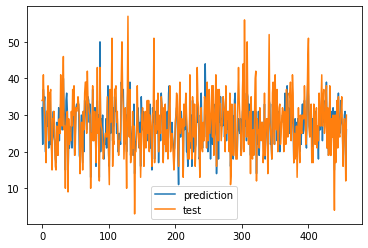

In [49]:
df_pred.plot()

### Metrics

In [50]:
metrics.explained_variance_score(y_test, y_pred)

0.576110375780206

In [51]:
metrics.mean_absolute_error(y_test, y_pred) 

4.03056768558952

In [52]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

5.26419893174765

In [53]:
metrics.mean_squared_log_error(y_test, y_pred)

0.03884087187994001

In [54]:
metrics.r2_score(y_test, y_pred)

0.569712170321538

### Cross Validation and Metrics 

In [55]:
r2_scores = cross_val_score(model,X_train, y_train, scoring='r2', cv=6)

In [56]:
mean_absolute_error=cross_val_score(model,X_train, y_train, scoring='neg_mean_absolute_error', cv=6)

In [57]:
root_mean_squared_error=cross_val_score(model,X_train, y_train, scoring='neg_root_mean_squared_error', cv=6)

In [58]:
mean_squared_log_error=cross_val_score(model,X_train, y_train, scoring='neg_mean_squared_log_error', cv=6)

In [59]:
explained_variance_score=cross_val_score(model,X_train,y_train, scoring="explained_variance",cv=6)

In [60]:
explained_variance_score.mean()

0.5672581814691476

In [61]:
r2_scores.mean()

0.5659265361357575

In [62]:
abs(mean_absolute_error.mean()).round()

4.0

In [63]:
abs(root_mean_squared_error.mean()).round()

5.0

In [64]:
abs(mean_squared_log_error.mean())

0.036874829393926174

In [65]:
predict=cross_val_predict(model,X_test,y_test,cv=6)

In [66]:
predict=predict.round()

In [67]:
df_cross_val_pred=pd.DataFrame({"pred":predict,"test":y_test})

<AxesSubplot:>

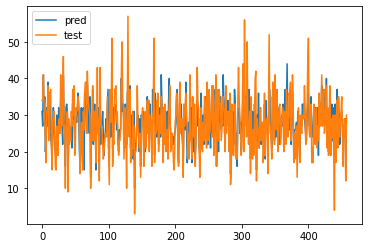

In [68]:
df_cross_val_pred.plot()